In [1]:
#Imports from project
from import_images import import_images_from_path
from cellpose_data import get_cellpose_probability_maps
from cellpose_data_trained_model import import_cellpose_model, get_cellpose_probability_maps_pre_trained
from random_crops import get_random_crops_from_multiple_images
from augment_data import rotate_images_and_cellprobs_return_merged
from make_prediction import split_image_into_crops, reconstruct_image_from_crops
from u_net import UNet

#Import from other libraries
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.optim import Adam
import os
import wandb

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#File directories
images_path = 'data/'

In [3]:
#Importing images
images = import_images_from_path(images_path,num_imgs=23,normalisation=True)

In [4]:
#Getting input data from Cellpose generalist
cell_probabilities_cellpose_generalist = get_cellpose_probability_maps(images)
cell_probabilities_cellpose_generalist = [(cellprob-np.min(cellprob))/(np.max(cellprob)-np.min(cellprob)) for cellprob in cell_probabilities_cellpose_generalist]

In [5]:
#Getting input data from Cellpose trained
model_path = 'models/CP_20230402_212503_3'
model = import_cellpose_model(model_path)
cell_probabilities_cellpose_trained = get_cellpose_probability_maps_pre_trained(model,images)
cell_probabilities_cellpose_trained = [(cellprob-np.min(cellprob))/(np.max(cellprob)-np.min(cellprob)) for cellprob in cell_probabilities_cellpose_trained]

In [6]:
#Getting input data from our own cellprobability map prediction model
#make U-net model
cellprob_model = UNet()
cellprob_model = cellprob_model.to('cuda:0')
cellprob_model.load_state_dict(torch.load('models/cellprob_model_0.pt'))

cell_probabilities_cellprob_model = []

for image in images:
    splitted = split_image_into_crops(image,128)
    preds_splitted = []
    for img in splitted:
        pred_split = cellprob_model(torch.unsqueeze(torch.unsqueeze(torch.from_numpy(img),0),0).to('cuda:0'))
        preds_splitted.append(pred_split.cpu().detach()[0][0])
    pred_reconstructed = reconstruct_image_from_crops(preds_splitted,128)
    cell_probabilities_cellprob_model.append(pred_reconstructed)

In [7]:
#get groundtruth masks from data_for_cellpose
#import the numpy files from the masks folder and binarise them
masks = []
for i in range(23):
    mask = np.load(os.getcwd()+'\\masks'+'\\'+str(i)+'_seg.npy',allow_pickle=True).item()['masks']
    mask = np.where(mask>0.5,1,0) #binarise the masks
    masks.append(mask)

In [8]:
#KEY
#cell_probabilities_cellpose_generalist = cg
#cell_probabilities_cellpose_trained = ct
#cell_probabilities_cellprob_model = cm

#I will have to train one model just to see if it works

In [9]:
cellprob_crops_cg, mask_crops_cg = get_random_crops_from_multiple_images(cell_probabilities_cellpose_generalist,masks,num_crops=10)
cellprob_crops_cg_augmented, mask_crops_cg_augmented = rotate_images_and_cellprobs_return_merged(cellprob_crops_cg,mask_crops_cg,angles=[90,180,270])
X_train_cg, X_test_cg, y_train_cg, y_test_cg = train_test_split(cellprob_crops_cg_augmented, mask_crops_cg_augmented, test_size=0.33, random_state=42)

In [10]:
cellprob_crops_ct, mask_crops_ct = get_random_crops_from_multiple_images(cell_probabilities_cellpose_trained,masks,num_crops=10)
cellprob_crops_ct_augmented, mask_crops_ct_augmented = rotate_images_and_cellprobs_return_merged(cellprob_crops_ct,mask_crops_ct,angles=[90,180,270])
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(cellprob_crops_ct_augmented, mask_crops_ct_augmented, test_size=0.33, random_state=42)

In [11]:
cellprob_crops_cm, mask_crops_cm = get_random_crops_from_multiple_images(cell_probabilities_cellprob_model,masks,num_crops=10)
cellprob_crops_cm_augmented, mask_crops_cm_augmented = rotate_images_and_cellprobs_return_merged(cellprob_crops_cm,mask_crops_cm,angles=[90,180,270])
X_train_cm, X_test_cm, y_train_cm, y_test_cm = train_test_split(cellprob_crops_cm_augmented, mask_crops_cm_augmented, test_size=0.33, random_state=42)

In [12]:
#weighted dice loss
def dice_loss(pred, target):
    smooth = 1.
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [337]:
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, activation_fn, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = activation_fn(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, activation_fn, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = activation_fn(inputs)    
        #inputs = torch.tensor(torch.where(inputs>0.5,1.0,0.0),requires_grad=True)   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, activation_fn, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = activation_fn(inputs)    
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, activation_fn, smooth=1):
        
        alpha = 0.8
        gamma = 2

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = activation_fn(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, activation_fn, smooth=1, alpha=0.5, beta=0.5):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = activation_fn(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.5, beta=0.5, gamma=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [358]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'dice coefficient',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs':{
            'value': 100
        },
        'learning_rate': {
            'values': [0.1,0.01,0.001,0.0001,0.00001,0.000001]
        },
        'batch_size': {
            'values': [1,2,4,8,16,32,64,128,256,512,1024]
        },
        'activation_function': {
            'values': ['sigmoid','=relu','tanh']
        },
        'optimiser': {
            'values': ['Adam','SGD','RMSprop']
        },
        'loss_function': {
            'values': ['BCELoss','DiceLoss','DiceBCELoss','IoULoss','FocalLoss','TverskyLoss','FocalTverskyLoss']
        },
        'dataset': {
            'values': ['cellpose generalist','cellpose trained','cellprob model']
        }
    }
}

In [359]:
#create a train function
#input are some hyperparameters
#output is the final test loss

def train_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config

        model = UNet()
        model = model.to('cuda:0')

        if config.dataset == 'cellpose generalist':
            X_train = X_train_cg
            X_test = X_test_cg
            y_train = y_train_cg
            y_test = y_test_cg
        elif config.dataset == 'cellpose trained':
            X_train = X_train_ct
            X_test = X_test_ct
            y_train = y_train_ct
            y_test = y_test_ct
        elif config.dataset == 'cellprob model':
            X_train = X_train_cm
            X_test = X_test_cm
            y_train = y_train_cm
            y_test = y_test_cm

        if config.loss_function == 'DiceBCELoss':
            loss_fn = DiceBCELoss()
        elif config.loss_function == 'BCELoss':
            loss_fn = nn.BCELoss()
        elif config.loss_function == 'DiceLoss':
            loss_fn = DiceLoss()
        elif config.loss_function == 'IoULoss':
            loss_fn = IoULoss()
        elif config.loss_function == 'FocalLoss':
            loss_fn = FocalLoss()
        elif config.loss_function == 'TverskyLoss':
            loss_fn = TverskyLoss()
        elif config.loss_function == 'FocalTverskyLoss':
            loss_fn = FocalTverskyLoss()

        if config.optimiser == 'Adam':
            optimiser = Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimiser == 'SGD':
            optimiser = torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimiser == 'RMSprop':
            optimiser = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)

        if config.activation_function == 'sigmoid':
            activation_fn = torch.sigmoid
        elif config.activation_function == 'relu':
            activation_fn = torch.relu
        elif config.activation_function == 'tanh':
            activation_fn = torch.tanh

        train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), batch_size=config.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)), batch_size=config.batch_size, shuffle=True)

        for epoch in range(config.epochs):
            dice = train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser)
            wandb.log({'dice coefficient': dice,"epoch": epoch})
   
def train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser):
    model.train()

    #get train loss
    total_train_loss_per_epoch = 0
    for i, (x, y) in enumerate(train_loader):


        x = x.type(torch.float32)
        y = y.type(torch.float32)
        (x,y) = (x.to('cuda:0'), y.to('cuda:0')) # sending the data to the device (cpu or GPU)
        x = x.unsqueeze(1)
        pred = model(x)# make a prediction
        loss = loss_fn(pred, y, activation_fn) # calculate the loss of that prediction
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        total_train_loss_per_epoch += loss.detach().item()

    total_train_loss_per_epoch /= len(train_loader)
   
    #get test loss
    total_test_loss_per_epoch = 0
    total_dice = 0
    with torch.no_grad():
        for images, cellprobs in test_loader:
            images = torch.unsqueeze(images,1)
            cellprobs = torch.unsqueeze(cellprobs,1)
            cellprobs = cellprobs.to(torch.float32)
            outputs = model(images)

            #outputs = activation_fn(outputs)
            loss = loss_fn(outputs, cellprobs, activation_fn)
            total_test_loss_per_epoch += loss.item()

            #calculate dice score
            outputs = activation_fn(outputs)
            outputs = torch.where(outputs>0.5,1.0,0.0)
            outputs = outputs.view(-1)
            cellprobs = cellprobs.view(-1)
            intersection = (outputs * cellprobs).sum()  
            dice = (2.*intersection+1)/(outputs.sum() + cellprobs.sum()+1)  
            total_dice += dice.item()
            

    total_test_loss_per_epoch /= len(test_loader)
    total_dice /= len(test_loader)

    return total_dice

In [347]:
sweep_id = wandb.sweep(sweep_config,project="cell-mask-U-Net")

Create sweep with ID: 6l8byhvi
Sweep URL: https://wandb.ai/rzuberi/cell-mask-U-Net/sweeps/6l8byhvi


In [360]:
wandb.agent(sweep_id,function=train_sweep)

wandb: Agent Starting Run: 5gwnwdx5 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 1
wandb: 	dataset: cellpose generalist
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	loss_function: IoULoss
wandb: 	optimiser: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [345]:
wandb.init(
    # set the wandb project where this run will be logged
    project="cell-mask-U-Net",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "dataset": "cellpose generalist",
    "epochs": 10,
    }
)


model = UNet()
model = model.to('cuda:0')

X_train = X_train_cg
X_test = X_test_cg
y_train = y_train_cg
y_test = y_test_cg
train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)), batch_size=32, shuffle=True)
activation_fn = torch.sigmoid
optimiser = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_fn = IoULoss()

epochs = 10
for epoch in range(epochs):
    dice_metric = train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser)
    wandb.log({"dice coefficient": dice_metric})

wandb.finish()

dice coefficient,▃▄▁▅▄▇▃▃█▃
dice coefficient,0.07839


In [341]:
model_testing = train_model(X_train_cg, X_test_cg, y_train_cg, y_test_cg)

5.1575391626101916e-05
5.002858779334929e-05
5.099220434203744e-05
5.0613076746230944e-05
5.3720756841357795e-05
5.161149201740045e-05
5.206801361055113e-05
5.118870067235548e-05
5.1145698307664134e-05
5.2051024613319893e-05
5.135635292390362e-05
5.035906251578126e-05
5.1298732796567495e-05
5.401749949669465e-05
5.148713717062492e-05
5.435536149889231e-05
5.1352607988519595e-05
5.34170863829786e-05
5.2993188364780505e-05
5.178133214940317e-05
5.086683449917473e-05
5.134058083058335e-05
5.496859703271184e-05
5.320083764672745e-05
5.08018012624234e-05
5.2546410006470976e-05
5.1792605518130586e-05
5.186900671105832e-05
5.156188053661026e-05
5.4604868637397885e-05
5.541591381188482e-05
5.108805598865729e-05
5.250390313449316e-05
5.2942492038710044e-05
5.30979894392658e-05
5.017605253669899e-05
5.2713308105012405e-05
5.101229362480808e-05
5.1399166841292755e-05
5.169621545064729e-05
5.331182437657844e-05
5.526861750695389e-05
5.2274652261985466e-05
5.015339665987994e-05
5.211543029872701e-0

KeyboardInterrupt: 

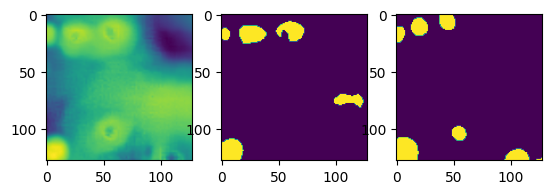

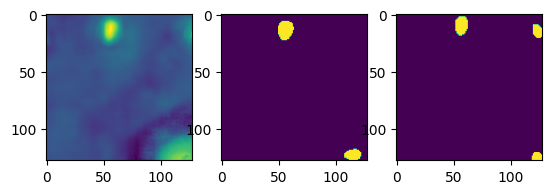

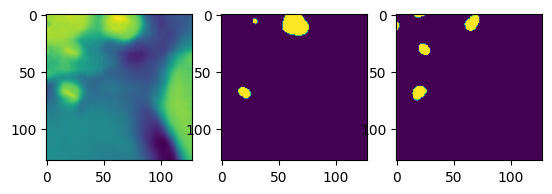

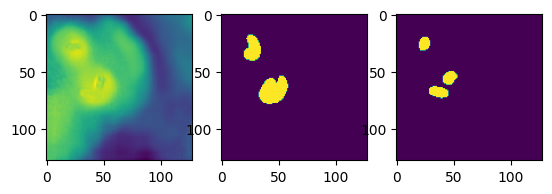

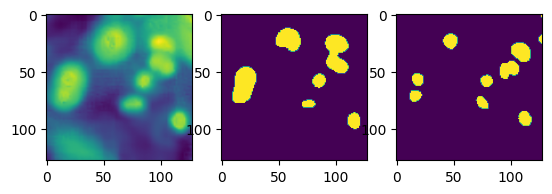

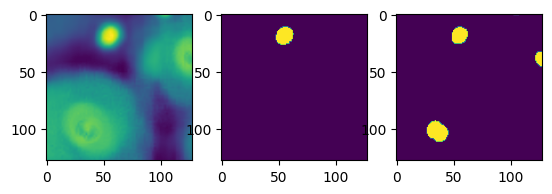

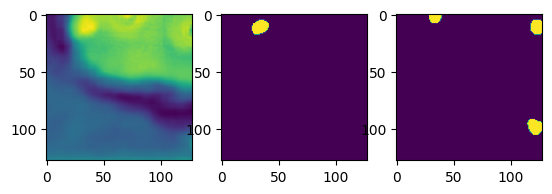

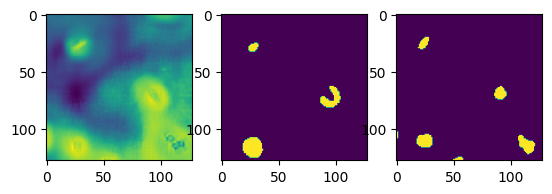

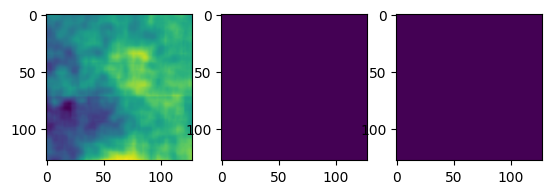

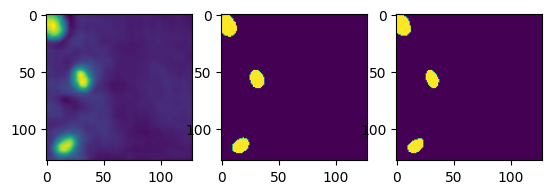

In [313]:
#make prediction from model_testing
import matplotlib.pyplot as plt

for index in range(10):

    plt.subplot(1,3,1)
    plt.imshow(X_test_cg[index].detach().cpu())

    pred = model_testing(torch.unsqueeze(torch.unsqueeze(X_test_cg[index],0),0))
    pred = torch.where(pred>0.5,1,0)

    plt.subplot(1,3,2)
    plt.imshow(pred[0,0,:,:].detach().cpu().numpy())

    plt.subplot(1,3,3)
    plt.imshow(y_test_cg[index].detach().cpu())

    plt.show()

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'test loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs':{
            'value': 200
        },
        'learning_rate': {
            'values': [0.1,0.01,0.001,0.0001,0.00001,0.000001]
        },
        'batch_size': {
            'values': [1,2,4,8,16,32,64,128,256,512,1024]
        },
        'activation_function': {
            'values': ['relu','leaky_relu','sigmoid','tanh']
        },
        'optimiser': {
            'values': ['Adam','SGD','RMSprop']
        },
        'loss_function': {
            'value': 'MSELoss'
        }
    }
}

In [ ]:
#create a train function
#input are some hyperparameters
#output is the final test loss

def train_sweep(X_train,X_test,y_train,y_test):
    model = UNet()
    model = model.to('cuda:0')

    if config.dataset == 'cellpose generalist':
        X_train = X_train_cg
        X_test = X_test_cg
        y_train = y_train_cg
        y_test = y_test_cg
    elif config.dataset == 'cellpose trained':
        X_train = X_train_ct
        X_test = X_test_ct
        y_train = y_train_ct
        y_test = y_test_ct
    elif config.dataset == 'cellprob model':
        X_train = X_train_cm
        X_test = X_test_cm
        y_train = y_train_cm
        y_test = y_test_cm

    train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)), batch_size=32, shuffle=True)

    if config.loss_function == 'MSELoss':
        loss_fn = torch.nn.MSELoss()

    if config.activation_function == 'relu':
        activation_fn = torch.nn.ReLU()
    elif config.activation_function == 'leaky_relu':
        activation_fn = torch.nn.LeakyReLU()
    elif config.activation_function == 'sigmoid':
        activation_fn = torch.nn.Sigmoid()
    elif config.activation_function == 'tanh':
        activation_fn = torch.nn.Tanh()
    
    if config.optimiser == 'Adam':
        optimiser = Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimiser == 'SGD':
        optimiser = torch.optim.SGD(model.parameters(), lr=config.learning_rate)
    elif config.optimiser == 'RMSprop':
        optimiser = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)

    for epoch in range(config.epochs):
        test_loss = train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser)
        wandb.log({"test loss": test_loss, "epoch": epoch})    



    

    loss_fn = DiceBCELoss()

    activation_fn = torch.nn.Sigmoid()
    
    optimiser = Adam(model.parameters(), lr=0.0001)

    for epoch in range(100):
        dice = train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser)
    return model
   
def train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser):
    model.train()

    #get train loss
    total_train_loss_per_epoch = 0
    for i, (x, y) in enumerate(train_loader):


        x = x.type(torch.float32)
        y = y.type(torch.float32)
        (x,y) = (x.to('cuda:0'), y.to('cuda:0')) # sending the data to the device (cpu or GPU)
        x = x.unsqueeze(1)
        pred = model(x)# make a prediction
        #print('pred 1 shape:',len(pred[0]))
        #print('pred 2 shape:',len(pred[1]))
        #print('y shape:',y.shape)
        loss = loss_fn(pred, y) # calculate the loss of that prediction
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        total_train_loss_per_epoch += loss.detach().item()

        
        #images = torch.unsqueeze(images,1)
        #cellprobs = torch.unsqueeze(cellprobs,1)
        #cellprobs = cellprobs.to(torch.float32)
        #outputs = model(images)
        #loss = loss_fn(outputs, cellprobs)
        #total_train_loss_per_epoch += loss.item()
        
        #optimiser.zero_grad()
        #loss.backward()
        #optimiser.step()
    total_train_loss_per_epoch /= len(train_loader)
   
    #get test loss
    total_test_loss_per_epoch = 0
    total_dice = 0
    with torch.no_grad():
        for images, cellprobs in test_loader:
            images = torch.unsqueeze(images,1)
            cellprobs = torch.unsqueeze(cellprobs,1)
            cellprobs = cellprobs.to(torch.float32)
            outputs = model(images)

            #outputs = activation_fn(outputs)
            loss = loss_fn(outputs, cellprobs)
            total_test_loss_per_epoch += loss.item()

            #calculat dice score
            outputs = activation_fn(outputs)
            outputs = torch.where(outputs>0.5,1.0,0.0)
            outputs = outputs.view(-1)
            cellprobs = cellprobs.view(-1)
            intersection = (outputs * cellprobs).sum()  
            dice = (2.*intersection+1)/(outputs.sum() + cellprobs.sum()+1)  
            total_dice += dice.item()
            

    total_test_loss_per_epoch /= len(test_loader)
    total_dice /= len(test_loader)

    return total_dice

In [15]:
print(agagaagag)

NameError: name 'agagaagag' is not defined

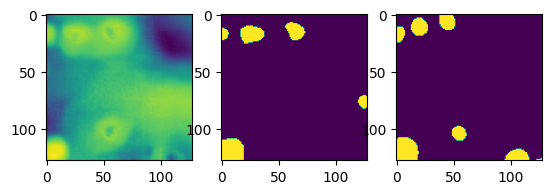

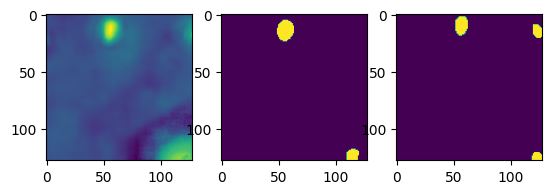

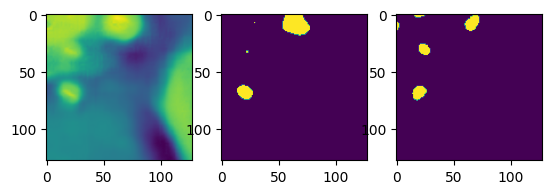

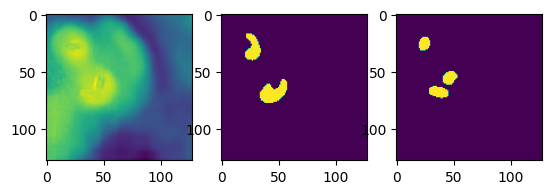

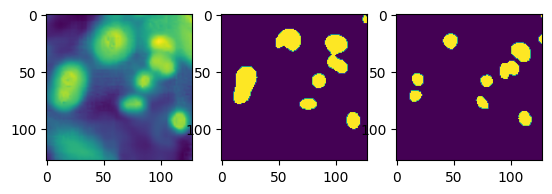

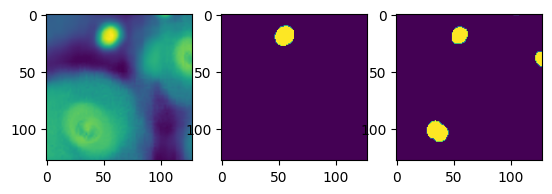

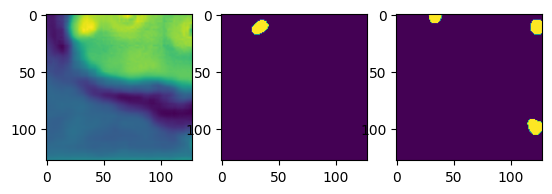

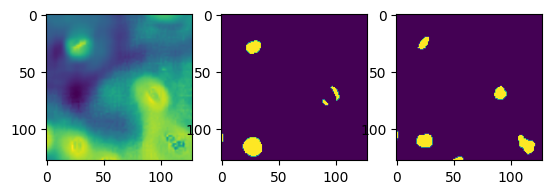

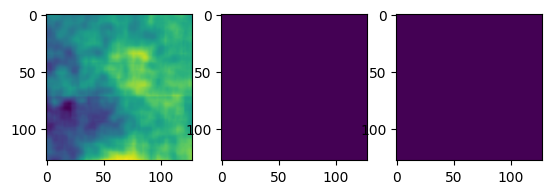

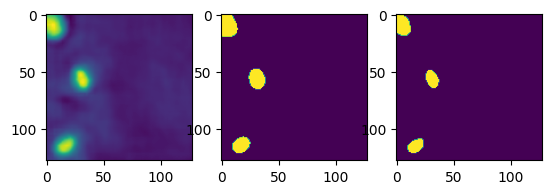

In [ ]:
#create a train function
#input are some hyperparameters
#output is the final test loss

def train_sweep(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        model = UNet()
        model = model.to('cuda:0')

        train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), batch_size=config.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)), batch_size=config.batch_size, shuffle=True)

        if config.loss_function == 'MSELoss':
            loss_fn = torch.nn.MSELoss()

        if config.activation_function == 'relu':
            activation_fn = torch.nn.ReLU()
        elif config.activation_function == 'leaky_relu':
            activation_fn = torch.nn.LeakyReLU()
        elif config.activation_function == 'sigmoid':
            activation_fn = torch.nn.Sigmoid()
        elif config.activation_function == 'tanh':
            activation_fn = torch.nn.Tanh()
       
        if config.optimiser == 'Adam':
            optimiser = Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimiser == 'SGD':
            optimiser = torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimiser == 'RMSprop':
            optimiser = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)

        for epoch in range(config.epochs):
            test_loss = train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser)
            wandb.log({"test loss": test_loss, "epoch": epoch})    
   
def train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser):
    model.train()

    #get train loss
    total_train_loss_per_epoch = 0
    for i, (images, cellprobs) in enumerate(train_loader):
        optimiser.zero_grad()
        images = torch.unsqueeze(images,1)
        cellprobs = torch.unsqueeze(cellprobs,1)
        outputs = model(images)
        outputs = activation_fn(outputs)
        loss = loss_fn(outputs, cellprobs)
        total_train_loss_per_epoch += loss.item()
        loss.backward()
        optimiser.step()
    total_train_loss_per_epoch /= len(train_loader)
   
    #get test loss
    total_test_loss_per_epoch = 0
    with torch.no_grad():
        for images, cellprobs in test_loader:
            images = torch.unsqueeze(images,1)
            cellprobs = torch.unsqueeze(cellprobs,1)
            outputs = model(images)
            outputs = activation_fn(outputs)
            loss = loss_fn(outputs, cellprobs)
            total_test_loss_per_epoch += loss.item()
    total_test_loss_per_epoch /= len(test_loader)

    return total_test_loss_per_epoch

In [ ]:
#Getting tensor crops of 128x128 from images
image_crops, cellprob_crops = get_random_crops_from_multiple_images(images,cell_probabilities_norm,num_crops=10)

In [ ]:
#Augmenting the data
image_crops_augmented, cellprob_crops_augmented = rotate_images_and_cellprobs_return_merged(image_crops,cellprob_crops,angles=[90,180,270])

In [ ]:
#Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_crops_augmented, cellprob_crops_augmented, test_size=0.33, random_state=42)

In [ ]:
print(torch.unsqueeze(y_test[0],0).shape)

torch.Size([1, 128, 128])


In [ ]:
print(y_test[0])

tensor([[0.4955, 0.5233, 0.5338,  ..., 0.6033, 0.6095, 0.6272],
        [0.4959, 0.5168, 0.5336,  ..., 0.6225, 0.6283, 0.6436],
        [0.4990, 0.5109, 0.5348,  ..., 0.6394, 0.6462, 0.6597],
        ...,
        [0.5211, 0.5235, 0.5257,  ..., 0.3105, 0.3053, 0.3036],
        [0.5233, 0.5265, 0.5272,  ..., 0.3125, 0.3055, 0.3028],
        [0.5329, 0.5323, 0.5304,  ..., 0.3195, 0.3101, 0.3054]],
       device='cuda:0')


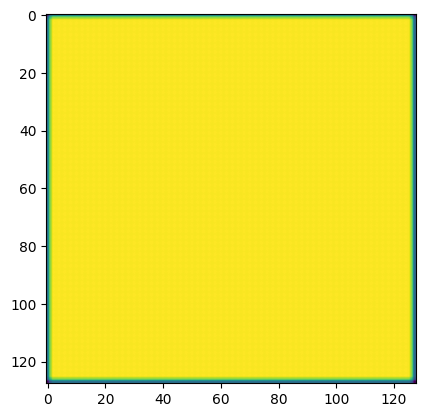

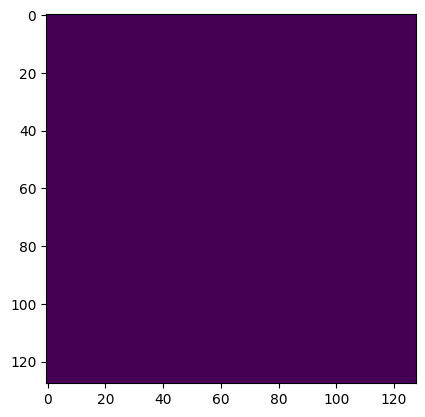

In [ ]:
import matplotlib.pyplot as plt
pred = model(torch.unsqueeze(torch.unsqueeze(y_test[2],0),0))
plt.imshow(pred.cpu().detach()[0][0])
plt.show()

plt.imshow(torch.nn.Sigmoid()(pred.cpu().detach()[0][0]))
plt.show()

In [ ]:
#Hyperparameters
learning_rate = 0.1
num_epochs = 10
batch_size = 32
loss_fn = torch.nn.MSELoss() #check in WANDB
activation_fn = torch.nn.Sigmoid()

#WANDB
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cell-probability-map-U-Net",
    
    # track hyperparameters and run metadata
    config={
    "learning rate": learning_rate,
    "epochs": num_epochs,
    "batch size": batch_size,
    "loss function": loss_fn,
    "number of training images":len(X_train),
    #VARIABLES TO CHECK
    "loss function": "MSE",
    "activation function": "Sigmoid",
    "size of crops": "128x128",
    "transformations": "rotations",
    }
)

#Initialising the model, we might need to do 256x256 crops in the end
model = UNet()
model = model.to('cuda:0')

#Get the dataloaders
train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)), batch_size=32, shuffle=True)

#Optimiser
opt = Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_train_loss_per_epoch = 0
    for i, (images, cellprobs) in enumerate(train_loader):
        opt.zero_grad()
        images = torch.unsqueeze(images,1)
        outputs = model(images)
        outputs = activation_fn(outputs)
        loss = loss_fn(outputs, cellprobs)
        total_train_loss_per_epoch += loss.item()
        loss.backward()
        opt.step()
    total_train_loss_per_epoch /= len(train_loader)
    wandb.log({"train loss": total_train_loss_per_epoch})
    train_losses.append(total_train_loss_per_epoch)
    
    #get test loss
    total_test_loss_per_epoch = 0
    with torch.no_grad():
        for images, cellprobs in test_loader:
            images = torch.unsqueeze(images,1)
            outputs = model(images)
            outputs = activation_fn(outputs)
            loss = loss_fn(outputs, cellprobs)
            total_test_loss_per_epoch += loss.item()
    total_test_loss_per_epoch /= len(test_loader)
    wandb.log({"test loss": total_test_loss_per_epoch})
    test_losses.append(total_test_loss_per_epoch)

    print('Epoch: {}/{} | Train Loss: {:.4f} | Test Loss: {:.4f}'.format(epoch+1, num_epochs, total_train_loss_per_epoch, total_test_loss_per_epoch))

wandb.finish()
    #might be iunteresting to get a prediction at each epoch from the test loss and visualise it to track its progress

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([32, 128, 128])) that is different to the input size (torch.Size([32, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1930, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.8146e+11, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1899e+19, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.5235e+16, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.0694e+18, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2888, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3656, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4007, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3943, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3994, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4037, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7662, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(20.5787, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(129.5825, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1618.1283, dev

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([8, 128, 128])) that is different to the input size (torch.Size([8, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([16, 128, 128])) that is different to the input size (torch.Size([16, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/10 | Train Loss: 850165741248530432.0000 | Test Loss: 40035.6152
tensor(42577.4102, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(61701.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(94750.9922, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(124483.5938, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(170801.9688, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(204515.7188, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(261438.9062, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(301745., device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(329122.2188, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(409612.1562, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(458694.1250, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(506298.4375, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(528560.7500, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(617428.5000, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(678475.5625, dev

test loss,▁▆████████
train loss,█▁▁▁▁▁▁▁▁▁
test loss,1293506.0375
train loss,1319249.90625
